<a href="https://colab.research.google.com/github/aayushjansari/Text-to-Music-Generator/blob/main/GenMusic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## Download the Maestro dataset

In [ ]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [ ]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


## Process a MIDI file

In [ ]:
sample_file = filenames[10]
print(sample_file)

data/maestro-v2.0.0/2008/MIDI-Unprocessed_02_R1_2008_01-05_ORIG_MID--AUDIO_02_R1_2008_wav--5.midi


In [ ]:
pm = pretty_midi.PrettyMIDI(sample_file)

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
display_audio(pm)

In [ ]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


## Extract notes

In [ ]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=65, note_name=F4, duration=1.5104
1: pitch=70, note_name=A#4, duration=1.4570
2: pitch=68, note_name=G#4, duration=1.5924
3: pitch=66, note_name=F#4, duration=1.8125
4: pitch=65, note_name=F4, duration=2.1172
5: pitch=61, note_name=C#4, duration=0.5352
6: pitch=63, note_name=D#4, duration=0.7174
7: pitch=65, note_name=F4, duration=1.6680
8: pitch=58, note_name=A#3, duration=0.1276
9: pitch=61, note_name=C#4, duration=0.0638


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head(10)

pitch      start        end      step  duration
0     65   0.912760   2.423177  0.000000  1.510417
1     70   2.316406   3.773438  1.403646  1.457031
2     68   3.677083   5.269531  1.360677  1.592448
3     66   5.186198   6.998698  1.509115  1.812500
4     65   6.890625   9.007812  1.704427  2.117188
5     61   8.886719   9.421875  1.996094  0.535156
6     63   9.363281  10.080729  0.476562  0.717448
7     65  10.057292  11.725260  0.694010  1.667969
8     46  12.382812  13.023438  2.325521  0.640625
9     53  12.502604  13.029948  0.119792  0.527344

In [ ]:
print(raw_notes)

      pitch       start         end      step  duration
0        65    0.912760    2.423177  0.000000  1.510417
1        70    2.316406    3.773438  1.403646  1.457031
2        68    3.677083    5.269531  1.360677  1.592448
3        66    5.186198    6.998698  1.509115  1.812500
4        65    6.890625    9.007812  1.704427  2.117188
...     ...         ...         ...       ...       ...
2325     65  321.683594  322.707031  0.005208  1.023438
2326     58  321.695312  322.548177  0.011719  0.852865
2327     58  324.785156  326.472656  3.089844  1.687500
2328     46  324.811198  326.372396  0.026042  1.561198
2329     34  324.833333  326.345052  0.022135  1.511719

[2330 rows x 5 columns]


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['F4', 'A#4', 'G#4', 'F#4', 'F4', 'C#4', 'D#4', 'F4', 'A#2', 'F3'],
      dtype='<U3')

In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

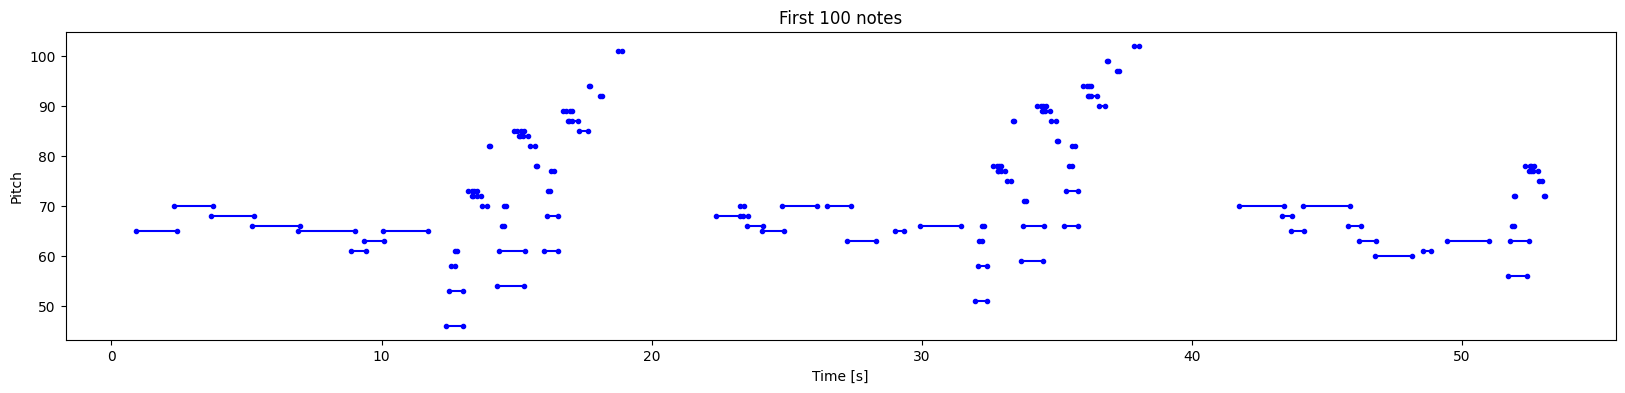

In [ ]:
plot_piano_roll(raw_notes, count=100)

Plot the notes for the entire track.

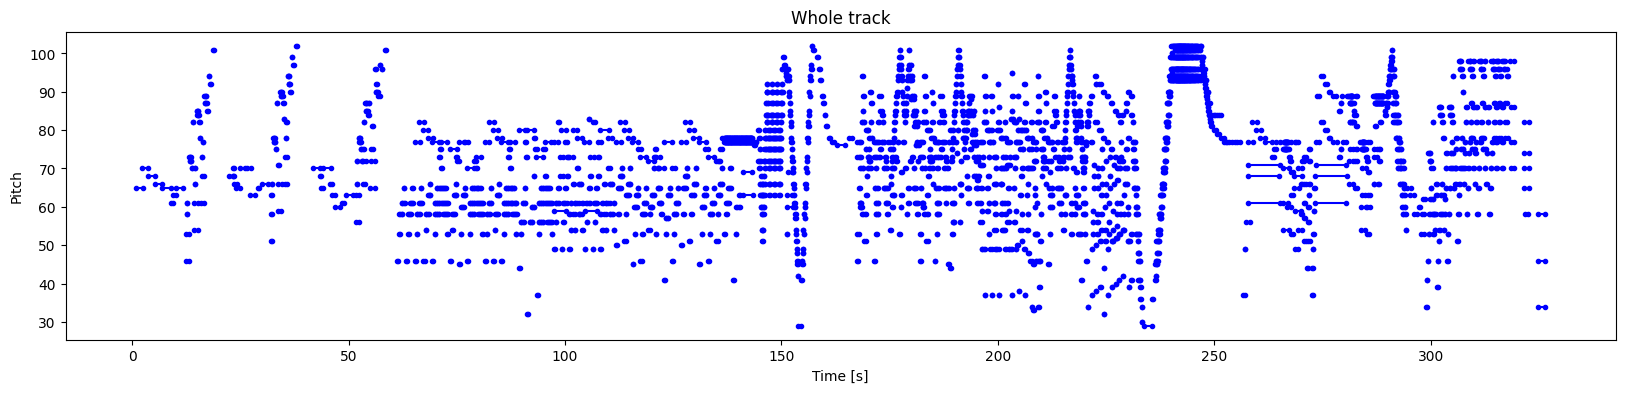

In [ ]:
plot_piano_roll(raw_notes)

Check the distribution of each note variable.

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

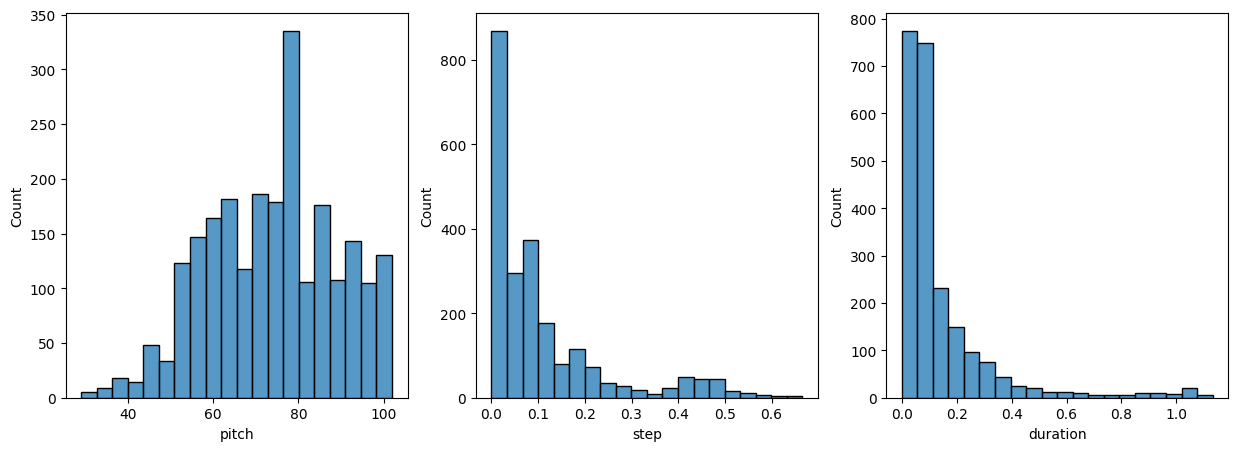

In [ ]:
plot_distributions(raw_notes)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

Play the generated MIDI file and see if there is any difference.

In [ ]:
display_audio(example_pm)

## Create the training dataset


In [ ]:
num_files = 5
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [ ]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 27314


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [ ]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.28125    0.         0.23307292]
 [0.375      0.24869792 0.08723958]
 [0.40625    0.2890625  0.1484375 ]
 [0.4296875  0.16145833 0.078125  ]
 [0.46875    0.15104167 0.03645833]
 [0.5        0.14583333 0.05598958]
 [0.5234375  0.12630208 0.10286458]
 [0.5625     0.16015625 0.07161458]
 [0.59375    0.11458333 0.04296875]
 [0.375      0.13020833 0.06901042]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=48.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.12630208333333304>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.08984375>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

## Create and train the model

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 25, 3)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 128)            │         67,584 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration (Dense)          │ (None, 1)              │            129 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pitch (Dense)             │ (None, 128)            │         16,512 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ step (Dense)              │ (None, 1)              │            129 │ lstm_1[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

426/426 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 5.5685


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'loss': 5.573199272155762}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.9577


{'loss': 0.962579071521759}

Train the model.

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/GenMusic/training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.3017
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2670
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2613
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2585
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2569
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2562
Epoch 7/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2551
Epoch 8/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.2537
Epoch 9/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2544
Epoch 10/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2550
Epoch 11/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2530
Epoch 12/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2494
Epoch 13/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2470
Epoch 14/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2450
Epoch 15/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - 

In [ ]:
model.save('/content/drive/MyDrive/GenMusic/my_music_gen_model.keras')


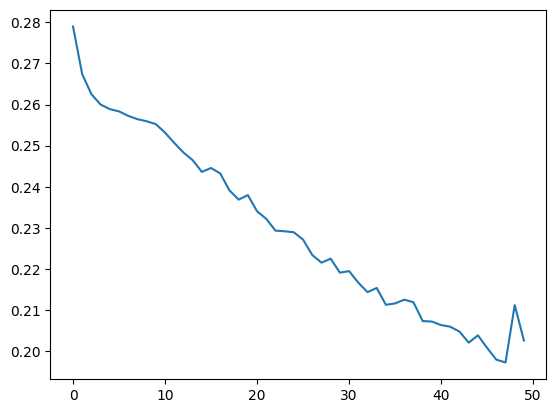

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

## Generate notes

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))
print(sample_notes)
print(input_notes)

[[6.50000000e+01 0.00000000e+00 1.51041667e+00]
 [7.00000000e+01 1.40364583e+00 1.45703125e+00]
 [6.80000000e+01 1.36067708e+00 1.59244792e+00]
 ...
 [5.80000000e+01 3.08984375e+00 1.68750000e+00]
 [4.60000000e+01 2.60416667e-02 1.56119792e+00]
 [3.40000000e+01 2.21354167e-02 1.51171875e+00]]
[[0.5078125  0.         1.51041667]
 [0.546875   1.40364583 1.45703125]
 [0.53125    1.36067708 1.59244792]
 [0.515625   1.50911458 1.8125    ]
 [0.5078125  1.70442708 2.1171875 ]
 [0.4765625  1.99609375 0.53515625]
 [0.4921875  0.4765625  0.71744792]
 [0.5078125  0.69401042 1.66796875]
 [0.359375   2.32552083 0.640625  ]
 [0.4140625  0.11979167 0.52734375]
 [0.453125   0.07682292 0.12760417]
 [0.4765625  0.13932292 0.06380208]
 [0.5703125  0.47916667 0.13802083]
 [0.5625     0.16015625 0.04166667]
 [0.5703125  0.07421875 0.08723958]
 [0.5625     0.09375    0.13932292]
 [0.546875   0.20963542 0.16536458]
 [0.640625   0.22916667 0.05598958]
 [0.421875   0.30729167 1.00520833]
 [0.4765625  0.0859375

In [ ]:
import pandas as pd
import random

def generate_music_row(emotion, genre):

    # Set default pitch, duration, and step based on emotion
    if emotion == "anger":
        pitch = random.randint(72, 88)
        duration = random.uniform(0.1, 0.4)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "fear":
        pitch = random.randint(48, 64)
        duration = random.uniform(0.3, 1.0)
        step = random.choice([1.0, 2.0])
    elif emotion == "joy":
        pitch = random.randint(68, 84)
        duration = random.uniform(0.25, 0.75)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "love":
        pitch = random.randint(58, 74)
        duration = random.uniform(0.4, 1.0)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "sadness":
        pitch = random.randint(48, 60)
        duration = random.uniform(0.6, 1.2)
        step = random.choice([1.0, 2.0])
    elif emotion == "surprise":
        pitch = random.randint(60, 80)
        duration = random.uniform(0.1, 0.5)
        step = random.choice([3.0, 4.0])
    else:
        raise ValueError("Invalid emotion: {}".format(emotion))

    # Adjust pitch, duration, and step based on genre
    if genre == "jazz":
        pitch += random.randint(-2, 2)  # Slightly varied pitch
        duration *= random.uniform(0.8, 1.2)  # Slightly longer notes
        step = random.choice([1.0, 1.5])  # Swing feel
    elif genre == "classical":
        pitch += random.randint(-4, 4)  # Broader pitch range
        duration *= random.uniform(1.0, 1.5)  # Longer, more expressive notes
        step = random.choice([1.0, 2.0])  # Smooth transitions
    elif genre == "indian classical":
        pitch += random.randint(60, 84)  # Richer, higher pitches
        duration *= random.uniform(1.0, 2.0)  # Very expressive with long notes
        step = random.choice([1.0, 1.5])  # Varying rhythms
    elif genre == "rock":
        pitch += random.randint(0, 4)  # Higher energy pitch
        duration *= random.uniform(0.3, 0.7)  # Medium to fast-paced
        step = random.choice([4.0, 5.0, 6.0])  # Fast, driving rhythm
    elif genre == "pop":
        pitch += random.randint(0, 4)  # Catchy, bright pitches
        duration *= random.uniform(0.2, 0.5)  # Short and catchy
        step = random.choice([2.0, 3.0])  # Simple, catchy rhythm
    elif genre == "electronic":
        pitch += random.randint(-4, 8)  # Wide pitch range for effects
        duration *= random.uniform(0.1, 0.3)  # Short notes for a fast pace
        step = random.choice([1.0, 2.0, 4.0])  # Varied rhythmic patterns
    else:
        raise ValueError("Invalid genre: {}".format(genre))

    start = random.uniform(0.0, 5.0)
    end = start + duration

    return {
        'pitch': pitch,
        'start': start,
        'end': end,
        'step': step,
        'duration': duration,

    }

def create_dataframe(emotion, genre, num_rows=25):

    data = [generate_music_row(emotion, genre) for _ in range(num_rows)]
    df = pd.DataFrame(data)
    return df

# Generate DataFrames for multiple emotions and genres
emotions = ["anger", "fear", "joy", "love", "sadness", "surprise"]
genres = ["jazz", "classical", "indian classical", "rock", "pop", "electronic"]
dataframes = {}
for emotion in emotions:
    for genre in genres:
        df_key = f"{emotion}_{genre}"
        dataframes[df_key] = create_dataframe(emotion, genre)

print(dataframes['joy_jazz'])


    pitch     start       end  step  duration
0      70  0.249432  0.575071   1.0  0.325638
1      75  4.199145  4.699601   1.5  0.500456
2      83  1.489502  2.137820   1.0  0.648318
3      81  2.231630  2.989358   1.5  0.757728
4      75  0.110896  0.723333   1.5  0.612437
5      76  0.985937  1.406382   1.5  0.420445
6      73  3.373655  3.805637   1.0  0.431982
7      76  4.052701  4.468558   1.5  0.415857
8      71  4.734566  5.326316   1.0  0.591750
9      84  1.051380  1.320042   1.0  0.268662
10     67  2.158887  2.760788   1.5  0.601900
11     81  0.822648  1.439128   1.5  0.616480
12     67  4.688725  5.467228   1.0  0.778503
13     73  0.091982  0.456649   1.5  0.364667
14     70  2.502814  2.958093   1.0  0.455278
15     76  2.515093  3.256973   1.5  0.741881
16     71  2.608236  2.958917   1.0  0.350681
17     76  3.648909  4.138478   1.5  0.489569
18     73  1.460443  1.980138   1.5  0.519695
19     75  3.061254  3.821308   1.5  0.760054
20     68  3.048330  3.626422   1.

In [ ]:
print(dataframes.keys())

dict_keys(['anger_jazz', 'anger_classical', 'anger_indian classical', 'anger_rock', 'anger_pop', 'anger_electronic', 'fear_jazz', 'fear_classical', 'fear_indian classical', 'fear_rock', 'fear_pop', 'fear_electronic', 'joy_jazz', 'joy_classical', 'joy_indian classical', 'joy_rock', 'joy_pop', 'joy_electronic', 'love_jazz', 'love_classical', 'love_indian classical', 'love_rock', 'love_pop', 'love_electronic', 'sadness_jazz', 'sadness_classical', 'sadness_indian classical', 'sadness_rock', 'sadness_pop', 'sadness_electronic', 'surprise_jazz', 'surprise_classical', 'surprise_indian classical', 'surprise_rock', 'surprise_pop', 'surprise_electronic'])


In [ ]:
temperature = 2.0
num_predictions = 400

input = 'love_jazz'

sample_notes = np.stack([dataframes[input][key] for key in key_order], axis=1)


input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

pitch      step  duration     start       end
0     65  0.504009  0.446635  0.504009  0.950643
1     72  0.124069  0.047900  0.628078  0.675977
2     79  0.163591  0.000000  0.791669  0.791669
3     47  0.170792  0.000000  0.962461  0.962461
4     72  0.152967  0.003528  1.115427  1.118956
5     76  0.168882  0.000000  1.284309  1.284309
6     50  0.169993  0.000000  1.454302  1.454302
7     74  0.157023  0.000000  1.611325  1.611325
8     84  0.171330  0.000000  1.782656  1.782656
9     63  0.177482  0.000000  1.960137  1.960137

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

Visualize the generated notes.

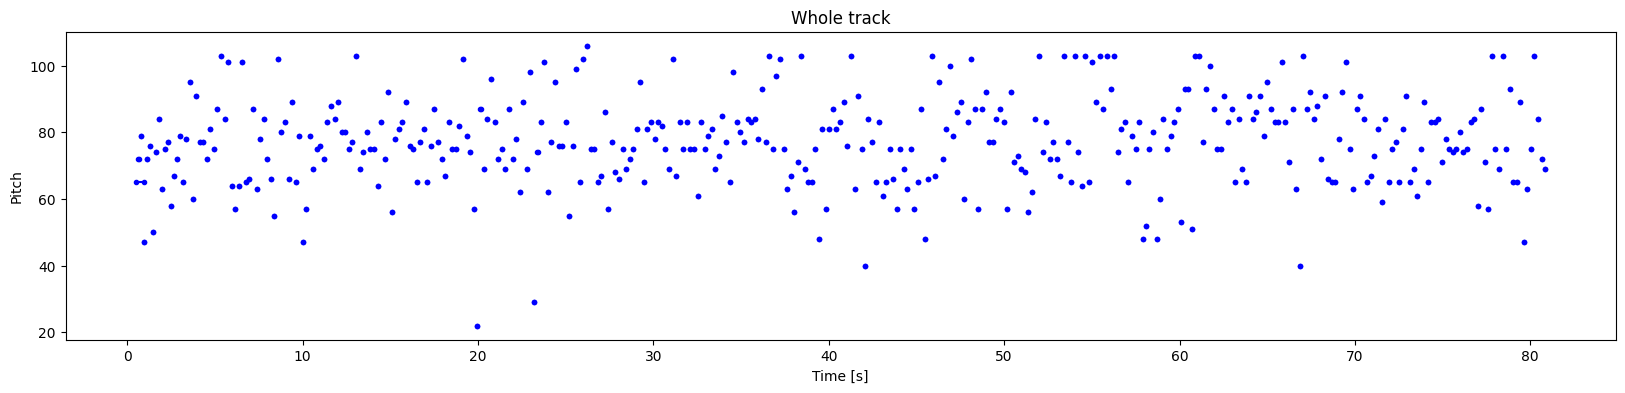

In [ ]:
plot_piano_roll(generated_notes)

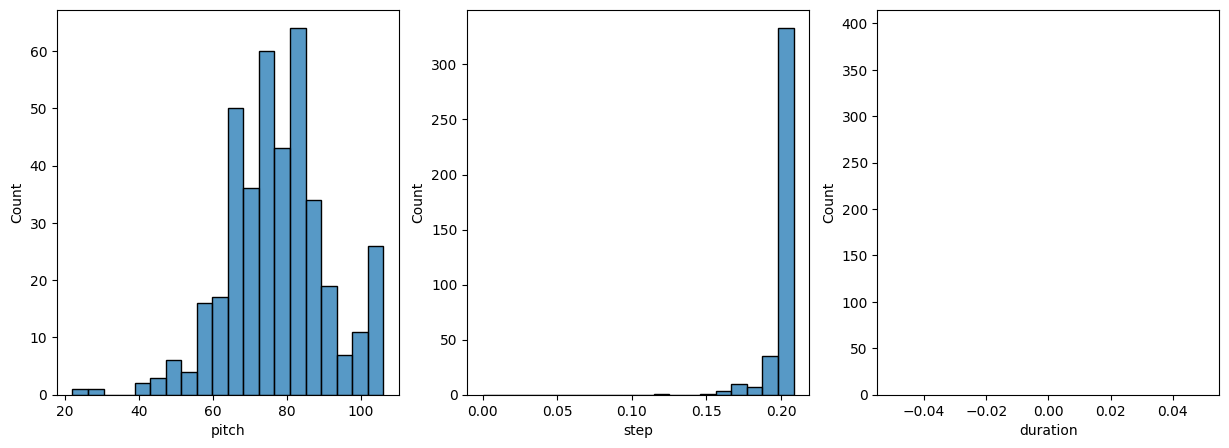

In [ ]:
plot_distributions(generated_notes)

# BERT Emotion Classification

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
encoded_to_class = {
    0: 'anger',
    1: 'fear',
    2: 'joy',
    3: 'love',
    4: 'sadness',
    5: 'surprise'
}

# Print the dictionary
print(encoded_to_class)

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}


In [ ]:
class BertSentimentClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertSentimentClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, 256)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(256, num_classes)


    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.dropout2(output)
        logits = self.fc2(output)

        return logits


bert_model_name = "bert-base-uncased"
num_classes = 6
BERTmodel = BertSentimentClassifier(bert_model_name, num_classes)

state_dict = torch.load('/content/drive/MyDrive/GenMusic/weights_epoch1.pt')

BERTmodel.load_state_dict(state_dict, strict=False)

BERTmodel.to(device)

BERTmodel.eval()

<ipython-input-139-de1bd1b326bb>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/content/drive/MyDrive/GenMusic/weights_epoch1.pt')


BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, e

# Suedo User Input


In [ ]:
input_text = "Dark rock music"


In [ ]:


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 150

encoded_input = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    truncation=True,
    max_length=max_len,  # Ensure max_len is defined
    return_token_type_ids=False,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt',
).to(device)

# Perform inference
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = BERTmodel(**encoded_input)

# Get the predicted emotion ID
emotion_id = torch.argmax(outputs, dim=1).item()



/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print(encoded_to_class[emotion_id])

sadness


# Emotion and Genre to Input Seed

In [ ]:
emotion = encoded_to_class[emotion_id]
genre = ""

for x in input_text.split():
  if x in genres:
      genre = x
      break
  else:
      genre = 'classical'
else:
    genre = 'classical'

print(emotion)
print(genre)

sadness
rock


In [ ]:
def get_dataframe_key(emotion, genre):
    return f"{emotion}_{genre}"


dataframe_key = get_dataframe_key(emotion, genre)
print(dataframe_key)


sadness_rock


In [ ]:
temperature = 2.0
num_predictions = 200

input = dataframe_key

sample_notes = np.stack([dataframes[input][key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

# Streamlit Deployment on ngrok tunnel

In [ ]:
!pip install streamlit

In [ ]:
!pip install pyngrok

In [ ]:
!pip install keras

In [ ]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np
import pretty_midi
import random
import tensorflow as tf
import torch
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
import pretty_midi

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

# Load models
from keras.models import load_model
model = load_model('/content/drive/MyDrive/GenMusic/my_music_gen_model.keras', custom_objects={'mse_with_positive_pressure': mse_with_positive_pressure})
bert_model_name = "bert-base-uncased"
bert_model = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Function to generate music based on emotion and genre
def generate_music_row(emotion, genre):
    if emotion == "anger":
        pitch = random.randint(72, 88)
        duration = random.uniform(0.1, 0.4)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "fear":
        pitch = random.randint(48, 64)
        duration = random.uniform(0.3, 1.0)
        step = random.choice([1.0, 2.0])
    elif emotion == "joy":
        pitch = random.randint(68, 84)
        duration = random.uniform(0.25, 0.75)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "love":
        pitch = random.randint(58, 74)
        duration = random.uniform(0.4, 1.0)
        step = random.choice([2.0, 3.0, 4.0])
    elif emotion == "sadness":
        pitch = random.randint(48, 60)
        duration = random.uniform(0.6, 1.2)
        step = random.choice([1.0, 2.0])
    elif emotion == "surprise":
        pitch = random.randint(60, 80)
        duration = random.uniform(0.1, 0.5)
        step = random.choice([3.0, 4.0])

    if genre == "jazz":
        pitch += random.randint(-2, 2)
        duration *= random.uniform(0.8, 1.2)
        step = random.choice([1.0, 1.5])
    elif genre == "classical":
        pitch += random.randint(-4, 4)
        duration *= random.uniform(1.0, 1.5)
        step = random.choice([1.0, 2.0])
    elif genre == "indian classical":
        pitch += random.randint(60, 84)
        duration *= random.uniform(1.0, 2.0)
        step = random.choice([1.0, 1.5])
    elif genre == "rock":
        pitch += random.randint(0, 4)
        duration *= random.uniform(0.3, 0.7)
        step = random.choice([4.0, 5.0, 6.0])
    elif genre == "pop":
        pitch += random.randint(0, 4)
        duration *= random.uniform(0.2, 0.5)
        step = random.choice([2.0, 3.0])
    elif genre == "electronic":
        pitch += random.randint(-4, 8)
        duration *= random.uniform(0.1, 0.3)
        step = random.choice([1.0, 2.0, 4.0])

    return {
        'pitch': pitch,
        'duration': duration,
        'step': step,
    }

# Generate a DataFrame of music notes
def create_dataframe(emotion, genre, num_rows=25):
    data = [generate_music_row(emotion, genre) for _ in range(num_rows)]
    df = pd.DataFrame(data)
    return df

# Streamlit app UI
st.title("Music Generation App")

# User inputs for emotion and genre
emotion = st.selectbox("Select Emotion", ["anger", "fear", "joy", "love", "sadness", "surprise"])
genre = st.selectbox("Select Genre", ["jazz", "classical", "indian classical", "rock", "pop", "electronic"])

# Generate music button
if st.button("Generate Music"):
    num_predictions = 200  # Number of notes to generate
    generated_notes = create_dataframe(emotion, genre, num_rows=num_predictions)

    # Convert DataFrame to MIDI
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program("Acoustic Grand Piano"))

    for _, row in generated_notes.iterrows():
        note = pretty_midi.Note(
            velocity=100,
            pitch=row['pitch'],
            start=row['step'],
            end=row['step'] + row['duration']
        )
        instrument.notes.append(note)

    pm.instruments.append(instrument)

    # Save generated MIDI
    midi_file_path = "generated_music.mid"
    pm.write(midi_file_path)

    st.success("Music Generated!")

    # Play the generated music
    st.audio(midi_file_path)

# Emotion prediction using BERT
st.header("Emotion Prediction")

input_text = st.text_input("Enter a description of the music:")
if st.button("Predict Emotion"):
    encoded_input = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        truncation=True,
        max_length=150,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = bert_model(**encoded_input)

    emotion_id = torch.argmax(outputs, dim=1).item()
    emotion_classes = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
    predicted_emotion = emotion_classes[emotion_id]

    st.write(f"Predicted Emotion: {predicted_emotion}")


Overwriting app.py


In [ ]:
!streamlit run app.py &>/dev/null &


In [ ]:
!ngrok authtoken 2n8gDmAYXPjE65djjmAl1Mg5qgb_2wCGEjoY7nMgYfj6QNmzH

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

# Create a public URL to access the Streamlit app
public_url = ngrok.connect("8501")
print(f'Public URL: {public_url}')


Public URL: NgrokTunnel: "https://8e1f-34-23-168-244.ngrok-free.app" -> "http://localhost:8501"
